## Imports & Setup

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape,AveragePooling2D,Bidirectional,GRU
import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt



In [ ]:
import sys
sys.path.append('/frn')
from frn.frn import FRN as FilterResponseNormalization

ModuleNotFoundError: No module named 'frn'

## Data Prep Functions

In [28]:
def train_data_prep(X,y,sub_sample,average,noise,time_limit):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:time_limit]
    #print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    #print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.6, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))

    #print('Shape of X after subsampling and concatenating:',total_X.shape)
    #print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X, time_limit):
    total_X = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:time_limit]
    #print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)

    total_X = X_max
    #print('Shape of X after maxpooling:',total_X.shape)

    return total_X

## Data Loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
X_test = np.load("/content/drive/MyDrive/c147 final project/X_test.npy")
y_test = np.load("/content/drive/MyDrive/c147 final project/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/c147 final project/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/c147 final project/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/c147 final project/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/c147 final project/person_test.npy")

y_train_valid -= 769
y_test -= 769

## CNN + LSTM Model
This model follows this architecture:
- N * (Conv2D - **Max Pool** - BatchNorm - Dropout)
- LSTM
- FC layer
- Softmax

The model takes parameters to adapt each of the layers.

In [16]:
def cnn_lstm(num_filters = [32], filter_size = 3, dropout = 0.6, activation_func = 'elu', dense_size = 100, lstm_dropout = 0.4, recurrent_dropout = 0.1, time_limit=800):
  hybrid_cnn_lstm_model = Sequential()

  # Conv layers
  for i in range(len(num_filters)):
    hybrid_cnn_lstm_model.add(Conv2D(filters=num_filters[i], kernel_size=(filter_size,filter_size), padding='same', activation=activation_func, input_shape=(time_limit//2,1,22)))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(dropout))

  # LSTM
  hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
  hybrid_cnn_lstm_model.add(Dense((dense_size))) # FC layer with 100 units
  hybrid_cnn_lstm_model.add(Reshape((dense_size,1))) # Reshape my output of FC layer so that it's compatible

  # removing recurrent dropout to speedup GPU
  # hybrid_cnn_lstm_model.add(LSTM(10, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout, input_shape=(dense_size,1), return_sequences=False))
  hybrid_cnn_lstm_model.add(LSTM(10, dropout=lstm_dropout, input_shape=(dense_size,1), return_sequences=False))

  # FC + softmax
  hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  return hybrid_cnn_lstm_model


## CNN + GRU Model
This model follows this architecture:
- N * (Conv2D - **Avg Pool** - BatchNorm - Dropout)
- LSTM
- FC layer
- Softmax

The model takes parameters to adapt each of the layers.

In [17]:
def cnn_bi(num_filters = [32], filter_size = 3, dropout = 0.6, activation_func = 'elu', dense_size = 100, lstm_dropout = 0.4, recurrent_dropout = 0.1, time_limit=800):
  hybrid_cnn_lstm_model = Sequential()

  # Conv layers
  for i in range(len(num_filters)):
    hybrid_cnn_lstm_model.add(Conv2D(filters=num_filters[i], kernel_size=(filter_size,filter_size), padding='same', activation=activation_func, input_shape=(time_limit//2,1,22)))
    hybrid_cnn_lstm_model.add(AveragePooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(dropout))

  # LSTM
  hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
  hybrid_cnn_lstm_model.add(Dense((dense_size))) # FC layer with 100 units
  hybrid_cnn_lstm_model.add(Reshape((dense_size,1))) # Reshape my output of FC layer so that it's compatible
  hybrid_cnn_lstm_model.add(Bidirectional(GRU(dense_size, return_sequences=True)))
  hybrid_cnn_lstm_model.add(Bidirectional(GRU(90, return_sequences=True)))
  hybrid_cnn_lstm_model.add(Bidirectional(GRU(60, return_sequences=False)))

  # FC + softmax
  hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  return hybrid_cnn_lstm_model

## CNN + GRU + LSTM Model (1)
This model follows this architecture:
- N * (Conv2D - **AVG** Pool - BatchNorm - Dropout)
- LSTM
- GRU
- FC layer
- Softmax

The model takes parameters to adapt each of the layers.

In [18]:
def cnn_lstm_bi(num_filters = [32], filter_size = 3, dropout = 0.6, activation_func = 'elu', dense_size = 100, lstm_dropout = 0.4, recurrent_dropout = 0.1, time_limit=800):
  hybrid_cnn_lstm_model = Sequential()

  # Conv layers
  for i in range(len(num_filters)):
    hybrid_cnn_lstm_model.add(Conv2D(filters=num_filters[i], kernel_size=(filter_size,filter_size), padding='same', activation=activation_func, input_shape=(time_limit//2,1,22)))
    hybrid_cnn_lstm_model.add(AveragePooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(dropout))

  # LSTM
  hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
  hybrid_cnn_lstm_model.add(Dense((dense_size))) # FC layer with 100 units
  hybrid_cnn_lstm_model.add(Reshape((dense_size,1))) # Reshape my output of FC layer so that it's compatible
  hybrid_cnn_lstm_model.add(LSTM(10, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout, input_shape=(dense_size,1), return_sequences=True))

  # GRU
  hybrid_cnn_lstm_model.add(Bidirectional(GRU(dense_size, return_sequences=True)))
  hybrid_cnn_lstm_model.add(Bidirectional(GRU(90, return_sequences=True)))
  hybrid_cnn_lstm_model.add(Bidirectional(GRU(60, return_sequences=False)))

  # FC + softmax
  hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  return hybrid_cnn_lstm_model

## CNN + GRU + LSTM Model (2)
This model follows this architecture:
- N * (Conv2D - **MAX** Pool - BatchNorm - Dropout)
- LSTM
- GRU
- FC layer
- Softmax

The model takes parameters to adapt each of the layers.

In [19]:
def cnn_lstm_bi_2(num_filters = [32], filter_size = 3, dropout = 0.6, activation_func = 'elu', dense_size = 100, lstm_dropout = 0.4, recurrent_dropout = 0.1, time_limit=800):
  hybrid_cnn_lstm_model = Sequential()

  # Conv layers
  for i in range(len(num_filters)):
    hybrid_cnn_lstm_model.add(Conv2D(filters=num_filters[i], kernel_size=(filter_size,filter_size), padding='same', activation=activation_func, input_shape=(time_limit//2,1,22)))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(dropout))

  # LSTM
  hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
  hybrid_cnn_lstm_model.add(Dense((dense_size))) # FC layer with 100 units
  hybrid_cnn_lstm_model.add(Reshape((dense_size,1))) # Reshape my output of FC layer so that it's compatible
  # getting rid of recurrent dropout
  # hybrid_cnn_lstm_model.add(LSTM(10, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout, input_shape=(dense_size,1), return_sequences=True))
  hybrid_cnn_lstm_model.add(LSTM(10, dropout=lstm_dropout, input_shape=(dense_size,1), return_sequences=True))

  # GRU
  hybrid_cnn_lstm_model.add(Bidirectional(GRU(dense_size, return_sequences=True)))
  hybrid_cnn_lstm_model.add(Bidirectional(GRU(90, return_sequences=True)))
  hybrid_cnn_lstm_model.add(Bidirectional(GRU(60, return_sequences=False)))

  # FC + softmax
  hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  return hybrid_cnn_lstm_model

##GRU


In [20]:
def gru(num_filters = [32], filter_size = 3, dropout = 0.6, activation_func = 'elu', dense_size = 100, lstm_dropout = 0.4, recurrent_dropout = 0.1, time_limit=800):
  hybrid_cnn_lstm_model = Sequential()

  # LSTM
  hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
  hybrid_cnn_lstm_model.add(Dense((dense_size))) # FC layer with 100 units
  hybrid_cnn_lstm_model.add(Reshape((dense_size,1))) # Reshape my output of FC layer so that it's compatible
  hybrid_cnn_lstm_model.add(Bidirectional(GRU(dense_size, return_sequences=True)))
  hybrid_cnn_lstm_model.add(Bidirectional(GRU(90, return_sequences=True)))
  hybrid_cnn_lstm_model.add(Bidirectional(GRU(60, return_sequences=False)))

  # FC + softmax
  hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  return hybrid_cnn_lstm_model

## Data filtering functions
These functions allow us to create train/valid & test sets with certain parameters. The possible parameters are:
- `subjects`:
  - If `None`, include all subjects
  - If of type `int`, include data from only this subject
  - If an array of ints, include data from all subjects in array
- `time_limit`: Specifies the duration of each trial to use. (Max is 1000, defaults to 800)

In [21]:
def train_val_data(subjects = None, time_limit = 800):
  if subjects is None: filter = lambda x: True
  elif type(subjects) == int: filter = lambda x: person_train_valid[x] == subjects
  else: filter = lambda x: person_train_valid[x] in subjects

  X_train_valid_filtered = np.array([X_train_valid[i] for i in range(len(X_train_valid)) if filter(i)])
  y_train_valid_filtered = np.array([y_train_valid[i] for i in range(len(y_train_valid)) if filter(i)])

  X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid_filtered,y_train_valid_filtered,2,2,True,time_limit)

  num_total = len(X_train_valid_prep)
  num_valid = int(0.10 * num_total)

  ind_valid = np.random.choice(num_total, num_valid, replace=False)
  ind_train = np.array(list(set(range(num_total)).difference(set(ind_valid))))

  (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
  (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]

  y_train = to_categorical(y_train, 4)
  y_valid = to_categorical(y_valid, 4)

  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)

  x_train = np.swapaxes(x_train, 1,3)
  x_train = np.swapaxes(x_train, 1,2)
  x_valid = np.swapaxes(x_valid, 1,3)
  x_valid = np.swapaxes(x_valid, 1,2)

  return x_train, y_train, x_valid, y_valid


def test_data(subjects = None, time_limit = 800):
  if subjects is None: filter = lambda x: True
  elif type(subjects) == int: filter = lambda x: person_test[x] == subjects
  else: filter = lambda x: person_test[x] in subjects
  X_test_filtered = np.array([X_test[i] for i in range(len(X_test)) if filter(i)])
  y_test_filtered = np.array([y_test[i] for i in range(len(y_test)) if filter(i)])

  ### RLY CONFUSED??

  X_test_prep = test_data_prep(X_test_filtered, time_limit)
  # X_test_prep = X_test_filtered


  y_test_filtered = to_categorical(y_test_filtered, 4)
  x_test_filtered = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)

  x_test_filtered = np.swapaxes(x_test_filtered, 1,3)
  x_test_filtered = np.swapaxes(x_test_filtered, 1,2)

  return x_test_filtered, y_test_filtered

## Train & test functions
These functions allow us to easily train and test a given model. Both of the functions take the model and data as parameters, and for the training we can specify the most important training params:
- `epochs`
- `batch_size`
- `lr`

Both functions return accuracy data.

In [22]:
def train(model, x_train, y_train, x_val, y_val, epochs = 100, batch_size = 100, lr = 1e-3, verbose = True):
  optimizer = keras.optimizers.Adam(learning_rate=lr)
  model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

  # Train and save train/val accuracies
  train_results = model.fit(x_train,
              y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val), verbose=verbose).history

  end_avg_train_acc = sum(train_results['accuracy'][-10:]) / 10
  end_avg_val_acc = sum(train_results['val_accuracy'][-10:]) / 10

  # returning the following for plotting
  trAcc, valAcc, trLoss, valLoss = train_results['accuracy'], train_results['val_accuracy'], train_results['loss'],train_results['val_loss']

  print("Average training accuracy of last 10 epochs: " + str(end_avg_train_acc) + "%")
  print("Average validation accuracy of last 10 epochs: " + str(end_avg_val_acc) + "%")

  return end_avg_train_acc, end_avg_val_acc, trAcc, valAcc, trLoss, valLoss

def test(model, x_test, y_test):
   test_acc = model.evaluate(x_test, y_test, verbose=0)[1]
   return test_acc

## Using our models
Starting here, the rest of the code uses the functions defined earlier to build, train & test models with varying parameters & data.

## CNN (All Subjects)


Building model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 400, 1, 15)        74265     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 134, 1, 15)        0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 134, 1, 15)        60        
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 134, 1, 15)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 134, 1, 10)        33760     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None,

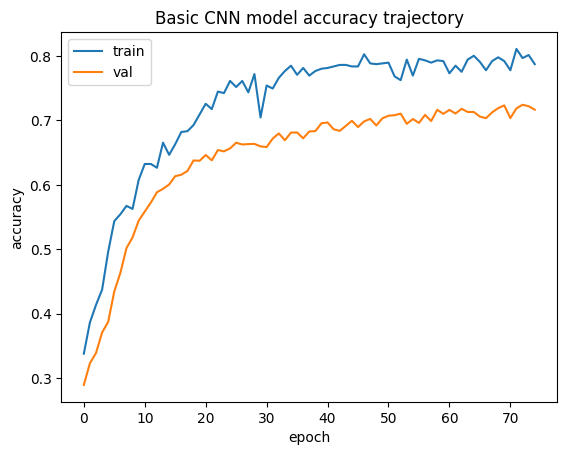

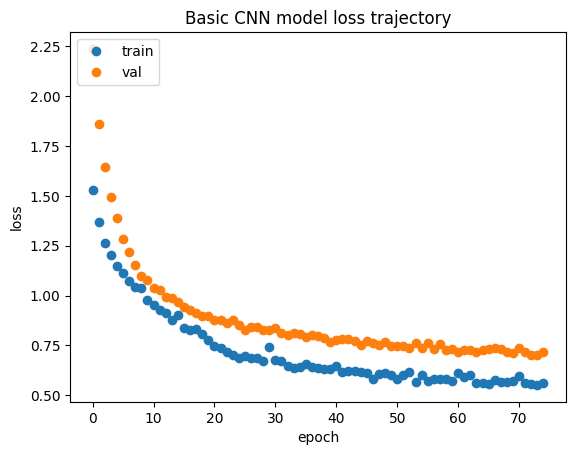

In [29]:
# hyper params
# Model parameters
num_filters = [25, 50, 100]
filter_size = 5
dropout = 0.55
activation_func = 'elu'
dense_size = 100
lstm_dropout = 0.33
recurrent_dropout = 0.1
time_limit=800 # Cuts data at this number of samples

# Training parameters
epochs = 75
batch_size = 200
lr = 1e-3
verbose = True

# Building the CNN standalone
model = Sequential()

# Conv. block 1
model.add(Conv2D(filters=15, kernel_size=(15,15), padding='same', activation=activation_func, input_shape=(400,1,22)))
model.add(MaxPooling2D(pool_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# Conv. block 2
model.add(Conv2D(filters=10, kernel_size=(15,15), padding='same', activation=activation_func))
model.add(MaxPooling2D(pool_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# FC+LSTM layers
model.add(Flatten()) # Adding a flattening operation to the output of CNN block
# hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
# hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible

# Output layer with Softmax activation
model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
print("\nBuilding model...")
model.summary()

# run and train instance of simple CNN across all test subjects
print("#### Training model all subjects for CNN")

# model = cnn_lstm(num_filters, filter_size, dropout, activation_func, dense_size, lstm_dropout, recurrent_dropout, time_limit)
print("\nBuilding train/val data")
x_train, y_train, x_val, y_val = train_val_data(subjects=None, time_limit=time_limit)
print("Using " + str(len(x_train)) + " training examples & " + str(len(x_val)) + " validation examples.")
print("\nTraining...")
_,_,trAcc, valAcc,trLoss,valLoss = train(model, x_train, y_train, x_val, y_val, epochs, batch_size, lr, verbose)
print("Finished training.")

# print("\nTesting on data from subject 1.")
# x_te, y_te = test_data(subjects=None, time_limit=time_limit)
# acc = test(model, x_te, y_te)
# print(str(acc) + "% accuracy on data from subject 1.")
print("\nTesting on data from all subjects.")
x_te, y_te = test_data(time_limit=time_limit)
acc = test(model, x_te, y_te)
print(str(acc) + "% accuracy on data from all subjects.")

import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(valAcc)
plt.plot(trAcc)

plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(valLoss,'o')
plt.plot(trLoss,'o')

plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##CNN + GRU


Building train/val data
Shape of X after averaging+noise and concatenating: (4230, 22, 400)
Using 7614 training examples & 846 validation examples.

Training...
Epoch 1/30
77/77 [==============================] - 19s 77ms/step - loss: 1.2996 - accuracy: 0.3618 - val_loss: 1.2259 - val_accuracy: 0.4563
Epoch 2/30
77/77 [==============================] - 3s 38ms/step - loss: 1.1885 - accuracy: 0.4543 - val_loss: 1.0854 - val_accuracy: 0.5071
Epoch 3/30
77/77 [==============================] - 3s 39ms/step - loss: 1.1546 - accuracy: 0.4775 - val_loss: 1.0474 - val_accuracy: 0.5142
Epoch 4/30
77/77 [==============================] - 3s 39ms/step - loss: 1.1266 - accuracy: 0.4866 - val_loss: 1.0369 - val_accuracy: 0.5378
Epoch 5/30
77/77 [==============================] - 3s 43ms/step - loss: 1.1076 - accuracy: 0.5125 - val_loss: 0.9882 - val_accuracy: 0.5733
Epoch 6/30
77/77 [==============================] - 3s 41ms/step - loss: 1.0782 - accuracy: 0.5338 - val_loss: 0.9630 - val_accuracy

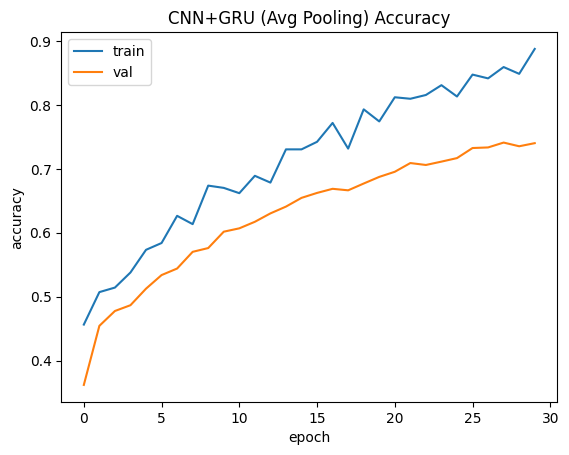

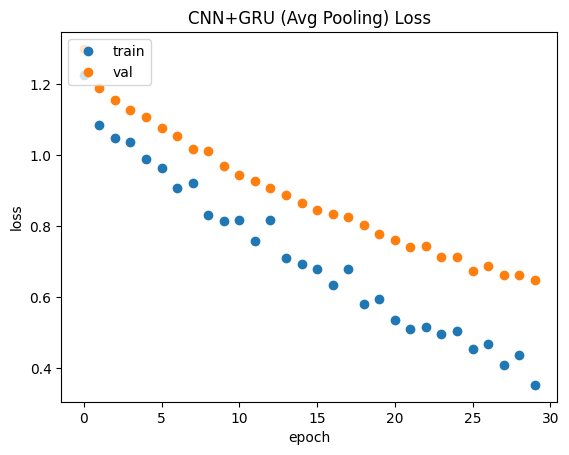

In [ ]:
# hyper params
# Model parameters
num_filters = [25, 50, 100, 200]
filter_size = 5
dropout = 0.6
activation_func = 'elu'
dense_size = 100
lstm_dropout = 0.4
recurrent_dropout = 0.1
time_limit=800 # Cuts data at this number of samples

# Training parameters
epochs = 30
batch_size = 100
lr = 1e-3
verbose = True


# call the cnn+lstm+gru model 2
model = cnn_bi(num_filters, filter_size, dropout, activation_func, dense_size, lstm_dropout, recurrent_dropout, time_limit)
print("\nBuilding train/val data")
x_train, y_train, x_val, y_val = train_val_data(subjects=None, time_limit=time_limit)
print("Using " + str(len(x_train)) + " training examples & " + str(len(x_val)) + " validation examples.")
print("\nTraining...")
_,_,trAcc, valAcc,trLoss,valLoss = train(model, x_train, y_train, x_val, y_val, epochs, batch_size, lr, verbose)
print("Finished training.")

print("\nTesting on data from all subjects.")
x_te, y_te = test_data(time_limit=time_limit)
acc = test(model, x_te, y_te)
print(str(acc) + "% accuracy on data from all subjects.")

import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(valAcc)
plt.plot(trAcc)
plt.title('CNN+GRU (Avg Pooling) Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(valLoss,'o')
plt.plot(trLoss,'o')
plt.title('CNN+GRU (Avg Pooling) Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##CNN + LSTM (All Subjects)

#### Training model ON all subjects. ###

Building model...

Building train/val data
Shape of X after averaging+noise and concatenating: (4230, 22, 400)
Using 7614 training examples & 846 validation examples.

Training...
Epoch 1/50
77/77 [==============================] - 6s 23ms/step - loss: 1.3625 - accuracy: 0.3097 - val_loss: 1.3055 - val_accuracy: 0.3865
Epoch 2/50
77/77 [==============================] - 1s 13ms/step - loss: 1.2818 - accuracy: 0.3920 - val_loss: 1.1969 - val_accuracy: 0.4362
Epoch 3/50
77/77 [==============================] - 1s 12ms/step - loss: 1.2142 - accuracy: 0.4232 - val_loss: 1.1651 - val_accuracy: 0.4622
Epoch 4/50
77/77 [==============================] - 1s 12ms/step - loss: 1.1712 - accuracy: 0.4611 - val_loss: 1.1180 - val_accuracy: 0.5083
Epoch 5/50
77/77 [==============================] - 1s 12ms/step - loss: 1.1350 - accuracy: 0.4926 - val_loss: 1.0575 - val_accuracy: 0.5449
Epoch 6/50
77/77 [==============================] - 1s 12ms/step - loss: 

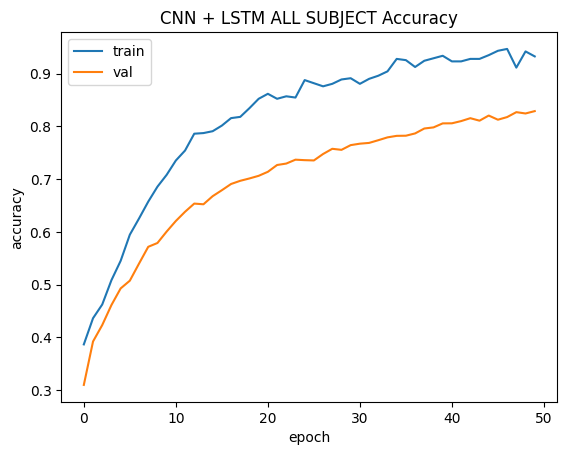

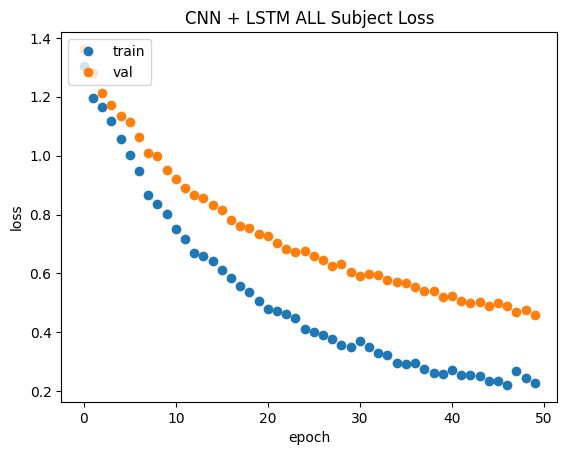

In [ ]:
# Model parameters
num_filters = [50, 100]
filter_size = 5
dropout = 0.58
activation_func = 'elu'
dense_size = 10
lstm_dropout = 0.33
#recurrent_dropout = 0.1
time_limit=800 # Cuts data at this number of samples

# Training parameters
epochs = 50
batch_size = 100
lr = 1e-3
verbose = True

print("#### Training model ON all subjects. ###")
print("\nBuilding model...")
model = cnn_lstm(num_filters, filter_size, dropout, activation_func, dense_size, lstm_dropout, recurrent_dropout, time_limit)
print("\nBuilding train/val data")
x_train, y_train, x_val, y_val = train_val_data(time_limit=time_limit)
print("Using " + str(len(x_train)) + " training examples & " + str(len(x_val)) + " validation examples.")
print("\nTraining...")
_,_,trAcc, valAcc,trLoss,valLoss = train(model, x_train, y_train, x_val, y_val, epochs, batch_size, lr, verbose)
print("Finished training.")

#print("\nTesting on data from subject 1.")
#x_te, y_te = test_data(subjects=1,time_limit=time_limit)
#acc = test(model, x_te, y_te)
#print(str(acc) + "% accuracy on data subject 1.")

print("\nTesting on data from all subjects.")
x_te, y_te = test_data(time_limit=time_limit)
acc = test(model, x_te, y_te)
print(str(acc) + "% accuracy on data from all subjects.")

import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(valAcc)
plt.plot(trAcc)
plt.title('CNN + LSTM ALL SUBJECT Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(valLoss,'o')
plt.plot(trLoss,'o')
plt.title('CNN + LSTM ALL Subject Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## CNN + LSTM (One Subject)

#### Training model ONLY on subject 1. ###

Building model...

Building train/val data
Shape of X after averaging+noise and concatenating: (472, 22, 400)
Using 850 training examples & 94 validation examples.

Training...
Epoch 1/45
19/19 [==============================] - 8s 78ms/step - loss: 1.3810 - accuracy: 0.2647 - val_loss: 1.3809 - val_accuracy: 0.2553
Epoch 2/45
19/19 [==============================] - 0s 10ms/step - loss: 1.3749 - accuracy: 0.2882 - val_loss: 1.3735 - val_accuracy: 0.3723
Epoch 3/45
19/19 [==============================] - 0s 15ms/step - loss: 1.3461 - accuracy: 0.3365 - val_loss: 1.3572 - val_accuracy: 0.4468
Epoch 4/45
19/19 [==============================] - 0s 20ms/step - loss: 1.3186 - accuracy: 0.3965 - val_loss: 1.3291 - val_accuracy: 0.5000
Epoch 5/45
19/19 [==============================] - 0s 12ms/step - loss: 1.2863 - accuracy: 0.4176 - val_loss: 1.3019 - val_accuracy: 0.6064
Epoch 6/45
19/19 [==============================] - 0s 10ms/step - loss: 1

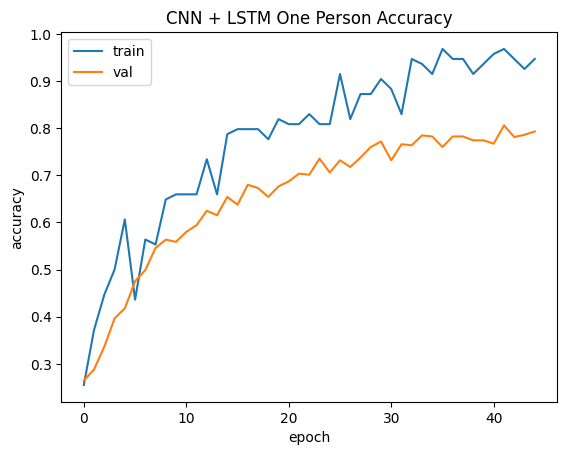

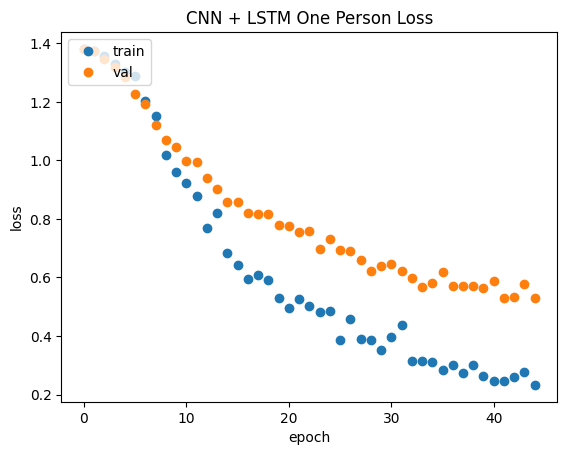

In [ ]:
# Model parameters
num_filters = [5, 100, 200]
filter_size = 5
dropout = 0.5
activation_func = 'elu'
dense_size = 5
lstm_dropout = 0.3
#recurrent_dropout = 0.1
time_limit=800 # Cuts data at this number of samples


# Training parameters
epochs = 45
batch_size = 45
lr = 1e-3
verbose = True

print("#### Training model ONLY on subject 1. ###")
print("\nBuilding model...")
model = cnn_lstm(num_filters, filter_size, dropout, activation_func, dense_size, lstm_dropout, recurrent_dropout, time_limit)
print("\nBuilding train/val data")
x_train, y_train, x_val, y_val = train_val_data(subjects=1, time_limit=time_limit)
print("Using " + str(len(x_train)) + " training examples & " + str(len(x_val)) + " validation examples.")
print("\nTraining...")
_,_,trAcc, valAcc,trLoss,valLoss = train(model, x_train, y_train, x_val, y_val, epochs, batch_size, lr, verbose)
print("Finished training.")

print("\nTesting on data from subject 1.")
x_te, y_te = test_data(subjects=1,time_limit=time_limit)
acc = test(model, x_te, y_te)
print(str(acc) + "% accuracy on data subject 1.")

print("\nTesting on data from all subjects.")
x_te, y_te = test_data(time_limit=time_limit)
acc = test(model, x_te, y_te)
print(str(acc) + "% accuracy on data from all subjects.")

import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(valAcc)
plt.plot(trAcc)
plt.title('CNN + LSTM One Person Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(valLoss,'o')
plt.plot(trLoss,'o')
plt.title('CNN + LSTM One Person Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#CNN + LSTM + GRU (Max Pool)


Building train/val data
Shape of X after averaging+noise and concatenating: (4230, 22, 400)
Using 7614 training examples & 846 validation examples.

Training...
Epoch 1/100
39/39 [==============================] - 19s 123ms/step - loss: 1.3736 - accuracy: 0.2840 - val_loss: 1.3266 - val_accuracy: 0.3511
Epoch 2/100
39/39 [==============================] - 2s 64ms/step - loss: 1.3303 - accuracy: 0.3492 - val_loss: 1.2681 - val_accuracy: 0.4078
Epoch 3/100
39/39 [==============================] - 3s 64ms/step - loss: 1.2703 - accuracy: 0.4022 - val_loss: 1.2357 - val_accuracy: 0.4208
Epoch 4/100
39/39 [==============================] - 3s 67ms/step - loss: 1.2262 - accuracy: 0.4250 - val_loss: 1.1710 - val_accuracy: 0.4645
Epoch 5/100
39/39 [==============================] - 2s 64ms/step - loss: 1.1983 - accuracy: 0.4483 - val_loss: 1.1514 - val_accuracy: 0.4929
Epoch 6/100
39/39 [==============================] - 2s 63ms/step - loss: 1.1799 - accuracy: 0.4584 - val_loss: 1.1585 - val_a

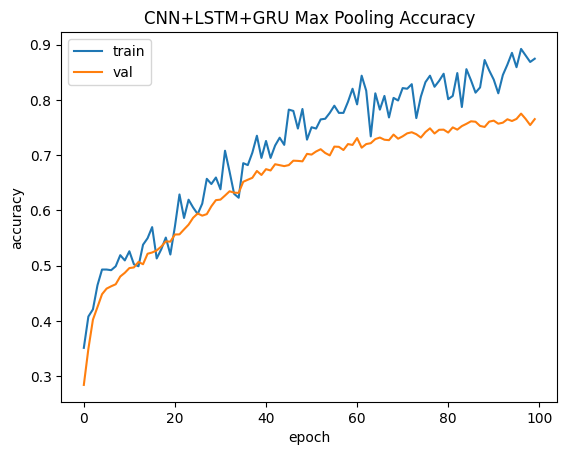

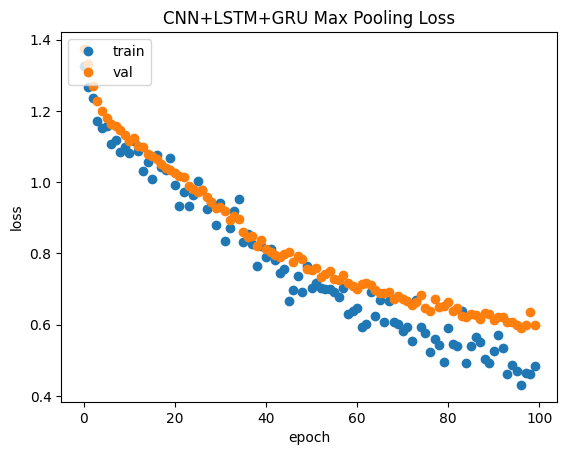

In [ ]:
# hyper params
# Model parameters
num_filters = [25, 50, 100, 200]
filter_size = 5
dropout = 0.6
activation_func = 'elu'
dense_size = 100
lstm_dropout = 0.4
recurrent_dropout = 0.1
time_limit=800 # Cuts data at this number of samples

# Training parameters
epochs = 100
batch_size = 200
lr = 1e-3
verbose = True


# call the cnn+lstm+gru model 2
model = cnn_lstm_bi_2(num_filters, filter_size, dropout, activation_func, dense_size, lstm_dropout, recurrent_dropout, time_limit)
print("\nBuilding train/val data")
x_train, y_train, x_val, y_val = train_val_data(subjects=None, time_limit=time_limit)
print("Using " + str(len(x_train)) + " training examples & " + str(len(x_val)) + " validation examples.")
print("\nTraining...")
_,_,trAcc, valAcc,trLoss,valLoss = train(model, x_train, y_train, x_val, y_val, epochs, batch_size, lr, verbose)
print("Finished training.")

print("\nTesting on data from all subjects.")
x_te, y_te = test_data(time_limit=time_limit)
acc = test(model, x_te, y_te)
print(str(acc) + "% accuracy on data from all subjects.")

import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(valAcc)
plt.plot(trAcc)
plt.title('CNN+LSTM+GRU Max Pooling Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(valLoss,'o')
plt.plot(trLoss,'o')
plt.title('CNN+LSTM+GRU Max Pooling Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


##CNN + LSTM + GRU (Avg Pooling)


Building train/val data
Shape of X after averaging+noise and concatenating: (4230, 22, 400)
Using 7614 training examples & 846 validation examples.

Training...
Epoch 1/20
77/77 [==============================] - 50s 452ms/step - loss: 1.2561 - accuracy: 0.4144 - val_loss: 1.1667 - val_accuracy: 0.4870
Epoch 2/20
77/77 [==============================] - 29s 371ms/step - loss: 1.0998 - accuracy: 0.5269 - val_loss: 0.9966 - val_accuracy: 0.5721
Epoch 3/20
77/77 [==============================] - 31s 404ms/step - loss: 0.9849 - accuracy: 0.5950 - val_loss: 0.8940 - val_accuracy: 0.6383
Epoch 4/20
77/77 [==============================] - 29s 374ms/step - loss: 0.9042 - accuracy: 0.6363 - val_loss: 0.7908 - val_accuracy: 0.7033
Epoch 5/20
77/77 [==============================] - 29s 374ms/step - loss: 0.8353 - accuracy: 0.6757 - val_loss: 0.9114 - val_accuracy: 0.6560
Epoch 6/20
77/77 [==============================] - 29s 379ms/step - loss: 0.7771 - accuracy: 0.7009 - val_loss: 0.6508 - v

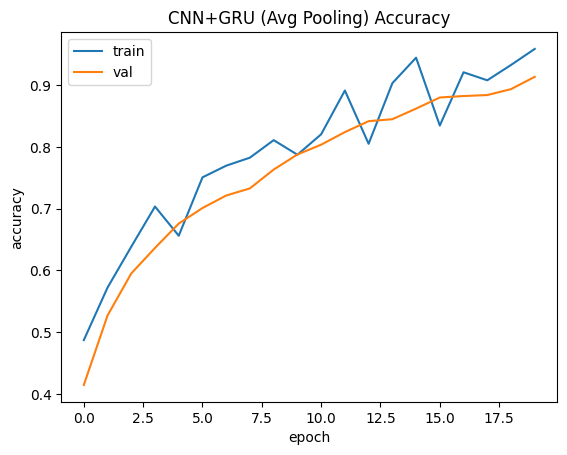

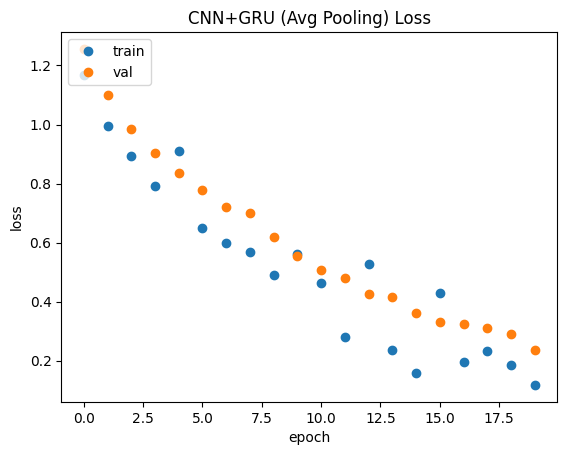

In [ ]:
# hyper params
# Model parameters
num_filters = [50, 100, 200]
filter_size = 5
dropout = 0.5
activation_func = 'elu'
dense_size = 100
lstm_dropout = 0.3
recurrent_dropout = 0.2
time_limit=800 # Cuts data at this number of samples

# Training parameters
epochs = 20
batch_size = 100
lr = 1e-3
verbose = True


# call the cnn+lstm+gru model 2
model = cnn_lstm_bi(num_filters, filter_size, dropout, activation_func, dense_size, lstm_dropout, recurrent_dropout, time_limit)
print("\nBuilding train/val data")
x_train, y_train, x_val, y_val = train_val_data(subjects=None, time_limit=time_limit)
print("Using " + str(len(x_train)) + " training examples & " + str(len(x_val)) + " validation examples.")
print("\nTraining...")
_,_,trAcc, valAcc,trLoss,valLoss = train(model, x_train, y_train, x_val, y_val, epochs, batch_size, lr, verbose)
print("Finished training.")

print("\nTesting on data from all subjects.")
x_te, y_te = test_data(time_limit=time_limit)
acc = test(model, x_te, y_te)
print(str(acc) + "% accuracy on data from all subjects.")

import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(valAcc)
plt.plot(trAcc)
plt.title('CNN+GRU (Avg Pooling) Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(valLoss,'o')
plt.plot(trLoss,'o')
plt.title('CNN+GRU (Avg Pooling) Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## FRN


Building model...
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_93 (Conv2D)          (None, 400, 1, 15)        74265     
                                                                 
 max_pooling2d_79 (MaxPooli  (None, 134, 1, 15)        0         
 ng2D)                                                           
                                                                 
 frn (FRN)                   (None, 134, 1, 15)        45        
                                                                 
 dropout_92 (Dropout)        (None, 134, 1, 15)        0         
                                                                 
 conv2d_94 (Conv2D)          (None, 134, 1, 10)        33760     
                                                                 
 max_pooling2d_80 (MaxPooli  (None, 45, 1, 10)         0         
 ng2D)                            

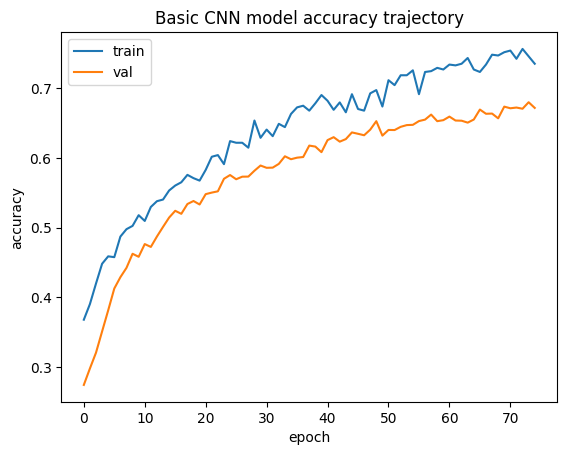

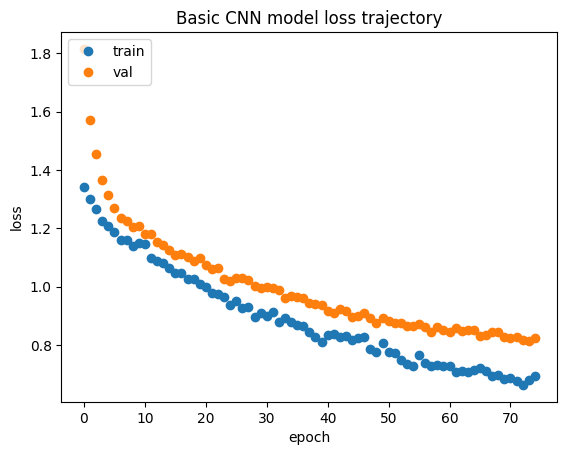

In [ ]:
# hyper params
# Model parameters
num_filters = [25, 50, 100]
filter_size = 5
dropout = 0.55
activation_func = 'elu'
dense_size = 100
lstm_dropout = 0.33
recurrent_dropout = 0.1
time_limit=800 # Cuts data at this number of samples

# Training parameters
epochs = 75
batch_size = 200
lr = 1e-3
verbose = True

# Building the CNN standalone
model = Sequential()

# Conv. block 1
model.add(Conv2D(filters=15, kernel_size=(15,15), padding='same', activation=activation_func, input_shape=(400,1,22)))
model.add(MaxPooling2D(pool_size=(3,3), padding='same'))
model.add(FilterResponseNormalization())
model.add(Dropout(0.6))

# Conv. block 2
model.add(Conv2D(filters=10, kernel_size=(15,15), padding='same', activation=activation_func))
model.add(MaxPooling2D(pool_size=(3,3), padding='same'))
model.add(FilterResponseNormalization())
model.add(Dropout(0.6))

# FC+LSTM layers
model.add(Flatten()) # Adding a flattening operation to the output of CNN block
# hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
# hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible

# Output layer with Softmax activation
model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
print("\nBuilding model...")
model.summary()

# run and train instance of simple CNN across all test subjects
print("#### Training model all subjects for CNN")

# model = cnn_lstm(num_filters, filter_size, dropout, activation_func, dense_size, lstm_dropout, recurrent_dropout, time_limit)
print("\nBuilding train/val data")
x_train, y_train, x_val, y_val = train_val_data(subjects=None, time_limit=time_limit)
print("Using " + str(len(x_train)) + " training examples & " + str(len(x_val)) + " validation examples.")
print("\nTraining...")
_,_,trAcc, valAcc,trLoss,valLoss = train(model, x_train, y_train, x_val, y_val, epochs, batch_size, lr, verbose)
print("Finished training.")

# print("\nTesting on data from subject 1.")
# x_te, y_te = test_data(subjects=None, time_limit=time_limit)
# acc = test(model, x_te, y_te)
# print(str(acc) + "% accuracy on data from subject 1.")
print("\nTesting on data from all subjects.")
x_te, y_te = test_data(time_limit=time_limit)
acc = test(model, x_te, y_te)
print(str(acc) + "% accuracy on data from all subjects.")

import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(valAcc)
plt.plot(trAcc)

plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(valLoss,'o')
plt.plot(trLoss,'o')

plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##GRU

In [ ]:
# hyper params
# Model parameters
num_filters = [25, 50, 100, 200]
filter_size = 5
dropout = 0.6
activation_func = 'elu'
dense_size = 100
lstm_dropout = 0.4
recurrent_dropout = 0.1
time_limit=800 # Cuts data at this number of samples

# Training parameters
epochs = 15
batch_size = 100
lr = 1e-3
verbose = True


# call the cnn+lstm+gru model 2
model = gru(num_filters, filter_size, dropout, activation_func, dense_size, lstm_dropout, recurrent_dropout, time_limit)
print("\nBuilding train/val data")
x_train, y_train, x_val, y_val = train_val_data(subjects=None, time_limit=time_limit)
print("Using " + str(len(x_train)) + " training examples & " + str(len(x_val)) + " validation examples.")
print("\nTraining...")
_,_,trAcc, valAcc,trLoss,valLoss = train(model, x_train, y_train, x_val, y_val, epochs, batch_size, lr, verbose)
print("Finished training.")

print("\nTesting on data from all subjects.")
x_te, y_te = test_data(time_limit=time_limit)
acc = test(model, x_te, y_te)
print(str(acc) + "% accuracy on data from all subjects.")

import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(valAcc)
plt.plot(trAcc)
plt.title('RNN Only (GRU) Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(valLoss,'o')
plt.plot(trLoss,'o')
plt.title('RNN Only (GRU) Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


Building train/val data
Shape of X after averaging+noise and concatenating: (4230, 22, 400)
Using 7614 training examples & 846 validation examples.

Training...
Epoch 1/15


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 4) and (None, 100, 4) are incompatible


### Hyperparameter Optimization
This block of code is designed specifically to help with optimization of hyperparameters. By iteratively training separate models while varying hyperparameters, we can attempt to understand how we should adjust the model for optimal performance.

In [ ]:
filter_options = [
    #[32],
    [50, 100, 200]                  # filter size 5: 42.3%                            3: 41.3%
    #[25, 50, 100, 200],           # Result with filter size 5 (5 epochs): 47%       filter size 3: 40.4%
    #[25, 50, 100, 200, 400],      # Result with filter size 5 (5 epochs): 37.5%     filter size 3: 33.1%
    #[25, 50, 100, 100, 200, 200]  # Result with filter size 5 (5 epochs): 41.6%     filter size 3: 24.8%
]

for option in filter_options:
  print("\nTesting for filters:", option)
  model = cnn_lstm(num_filters = option, filter_size = 3, recurrent_dropout = 0.2, lstm_dropout = 0.3, dropout = 0.4)

  x_train, y_train, x_val, y_val = train_val_data()
  x_te, y_te = test_data()

  train(model, x_train, y_train, x_val, y_val, epochs = 3, verbose = True)
  print("Test accuracy:" + str(test(model, x_te, y_te)))

### Accuracy as a function of time
In this block of code, the goal is to determine how accuracy is impacted by the duration of the trial. To do so, we train separate models with different lengths of trials, and compare their performance.

In [ ]:
# Model parameters
num_filters = [25, 50, 100, 200]
filter_size = 3
dropout = 0.6
activation_func = 'elu'
dense_size = 100
lstm_dropout = 0.4
recurrent_dropout = 0.1
time_limit=800 # Cuts data at this number of samples


# Training parameters
epochs = 50
batch_size = 200
lr = 1e-3
verbose = False


print("#### Determining accuracy as a function of time ####")
time_limits = [10, 30, 50, 100, 200, 300, 400, 500, 600, 800, 1000]
print("Testing for times:", time_limits)
train_accs, val_accs, test_accs = [], [], []
for limit in time_limits:
  print("Testing for time_limit="+str(limit)+"...")
  model = cnn_lstm(num_filters, filter_size, dropout, activation_func, dense_size, lstm_dropout, recurrent_dropout, limit)
  x_train, y_train, x_val, y_val = train_val_data(time_limit=limit)
  x_te, y_te = test_data(time_limit=limit)
  end_avg_train_acc, end_avg_val_acc = train(model, x_train, y_train, x_val, y_val, epochs, batch_size, lr, verbose)
  test_acc = test(model, x_te, y_te)

  train_accs.append(end_avg_train_acc)
  val_accs.append(end_avg_val_acc)
  test_accs.append(test_acc)

plt.plot(time_limits, train_accs)
plt.plot(time_limits, val_accs)
plt.plot(time_limits, test_accs)
plt.legend(['Training Acc.', 'Validation Acc.', 'Test Acc.'])
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.show()

### Training on a single subject
In the following block of code, we experiment with training a model exclusively on a single subject's data. We then test it first on data from that same subject, then data from all subjects to see how it generalizes.

In [ ]:
# Model parameters
num_filters = [25, 50, 100, 200]
filter_size = 5
dropout = 0.6
activation_func = 'elu'
dense_size = 100
lstm_dropout = 0.4
recurrent_dropout = 0.1
time_limit=800 # Cuts data at this number of samples


# Training parameters
epochs = 80
batch_size = 200
lr = 1e-3
verbose = True


print("#### Determining accuracy as a function of time ####")
time_limits = [800]
print("Testing for times:", time_limits)
train_accs, val_accs, test_accs = [], [], []
for limit in time_limits:
  print("Testing for time_limit="+str(limit)+"...")
  model = cnn_bi(num_filters, filter_size, dropout, activation_func, dense_size, lstm_dropout, recurrent_dropout, limit)
  x_train, y_train, x_val, y_val = train_val_data(time_limit=limit)
  x_te, y_te = test_data(time_limit=limit)
  end_avg_train_acc, end_avg_val_acc = train(model, x_train, y_train, x_val, y_val, epochs, batch_size, lr, verbose)
  test_acc = test(model, x_te, y_te)

  train_accs.append(end_avg_train_acc)
  val_accs.append(end_avg_val_acc)
  test_accs.append(test_acc)

#Dust Bin

In [ ]:
# Model parameters
num_filters = [5]
filter_size = 5
dropout = 0.6
activation_func = 'elu'
dense_size = 100
lstm_dropout = 0.4
recurrent_dropout = 0.1
time_limit=800 # Cuts data at this number of samples


# Training parameters
epochs = 30
batch_size = 55
lr = 1e-3
verbose = True

print("#### Training model ONLY on subject 1. ###")
print("\nBuilding model...")
model = cnn_lstm(num_filters, filter_size, dropout, activation_func, dense_size, lstm_dropout, recurrent_dropout, time_limit)
print("\nBuilding train/val data")
x_train, y_train, x_val, y_val = train_val_data(subjects=1, time_limit=time_limit)
print("Using " + str(len(x_train)) + " training examples & " + str(len(x_val)) + " validation examples.")
print("\nTraining...")
train(model, x_train, y_train, x_val, y_val, epochs, batch_size, lr, verbose)
print("Finished training.")
print("\nTesting on data from subject 1.")
x_te, y_te = test_data(subjects=1, time_limit=time_limit)
acc = test(model, x_te, y_te)
print(str(acc) + "% accuracy on data from subject 1.")
print("\nTesting on data from all subjects.")
x_te, y_te = test_data(time_limit=time_limit)
acc = test(model, x_te, y_te)
print(str(acc) + "% accuracy on data from all subjects.")


Building model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 400, 1, 15)        74265     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 134, 1, 15)        0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 134, 1, 15)        60        
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 134, 1, 15)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 134, 1, 10)        33760     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None,

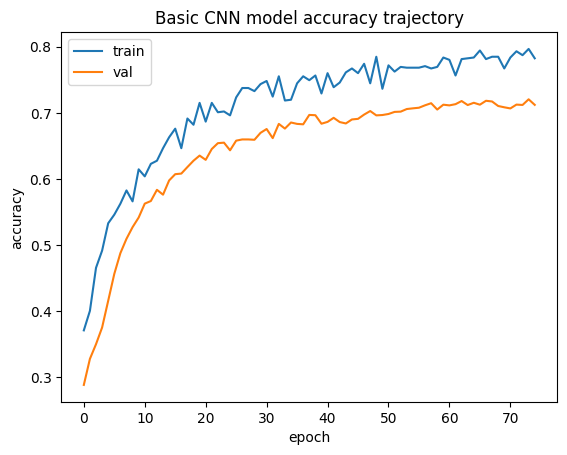

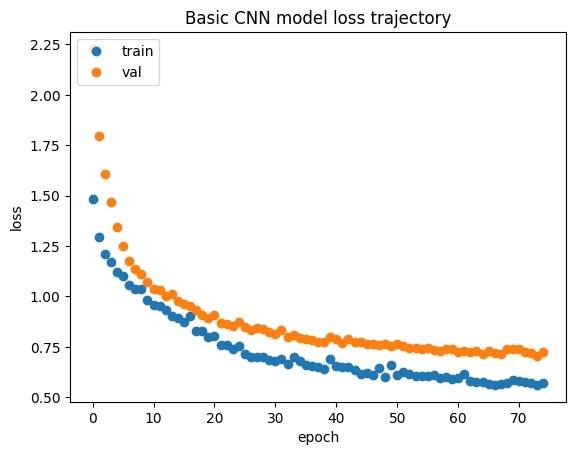

In [ ]:
# hyper params
# Model parameters
num_filters = [25, 50, 100, 200]
filter_size = 5
dropout = 0.6
activation_func = 'elu'
dense_size = 100
lstm_dropout = 0.4
recurrent_dropout = 0.1
time_limit=800 # Cuts data at this number of samples

# Training parameters
epochs = 75
batch_size = 200
lr = 1e-3
verbose = True

# Building the CNN standalone
model = Sequential()

# Conv. block 1
model.add(Conv2D(filters=15, kernel_size=(15,15), padding='same', activation=activation_func, input_shape=(400,1,22)))
model.add(MaxPooling2D(pool_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# Conv. block 2
model.add(Conv2D(filters=10, kernel_size=(15,15), padding='same', activation=activation_func))
model.add(MaxPooling2D(pool_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

# FC+LSTM layers
model.add(Flatten()) # Adding a flattening operation to the output of CNN block
# hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
# hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible

# Output layer with Softmax activation
model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
print("\nBuilding model...")
model.summary()

# run and train instance of simple CNN across all test subjects
print("#### Training model all subjects for CNN")

# model = cnn_lstm(num_filters, filter_size, dropout, activation_func, dense_size, lstm_dropout, recurrent_dropout, time_limit)
print("\nBuilding train/val data")
x_train, y_train, x_val, y_val = train_val_data(subjects=None, time_limit=time_limit)
print("Using " + str(len(x_train)) + " training examples & " + str(len(x_val)) + " validation examples.")
print("\nTraining...")
_,_,trAcc, valAcc,trLoss,valLoss = train(model, x_train, y_train, x_val, y_val, epochs, batch_size, lr, verbose)
print("Finished training.")

# print("\nTesting on data from subject 1.")
# x_te, y_te = test_data(subjects=None, time_limit=time_limit)
# acc = test(model, x_te, y_te)
# print(str(acc) + "% accuracy on data from subject 1.")
print("\nTesting on data from all subjects.")
x_te, y_te = test_data(time_limit=time_limit)
acc = test(model, x_te, y_te)
print(str(acc) + "% accuracy on data from all subjects.")

import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(valAcc)
plt.plot(trAcc)

plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(valLoss,'o')
plt.plot(trLoss,'o')

plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
batch_size = 128
num_classes = 10
epochs = 12

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(FRN())  # FRN or BatchNormalization
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(FRN())  # FRN or BatchNormalization
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

NameError: name 'input_shape' is not defined

#### Training model ONLY on subject 1. ###

Building model...

Building train/val data
Shape of X after averaging+noise and concatenating: (472, 22, 400)
Using 850 training examples & 94 validation examples.

Training...
Epoch 1/60
16/16 [==============================] - 5s 62ms/step - loss: 1.3828 - accuracy: 0.2788 - val_loss: 1.3624 - val_accuracy: 0.3723
Epoch 2/60
16/16 [==============================] - 0s 16ms/step - loss: 1.3631 - accuracy: 0.3129 - val_loss: 1.3272 - val_accuracy: 0.5000
Epoch 3/60
16/16 [==============================] - 0s 15ms/step - loss: 1.3280 - accuracy: 0.3765 - val_loss: 1.2902 - val_accuracy: 0.5106
Epoch 4/60
16/16 [==============================] - 0s 15ms/step - loss: 1.2870 - accuracy: 0.4224 - val_loss: 1.2461 - val_accuracy: 0.5319
Epoch 5/60
16/16 [==============================] - 0s 16ms/step - loss: 1.2474 - accuracy: 0.4459 - val_loss: 1.1836 - val_accuracy: 0.5532
Epoch 6/60
16/16 [==============================] - 0s 17ms/step - loss: 1

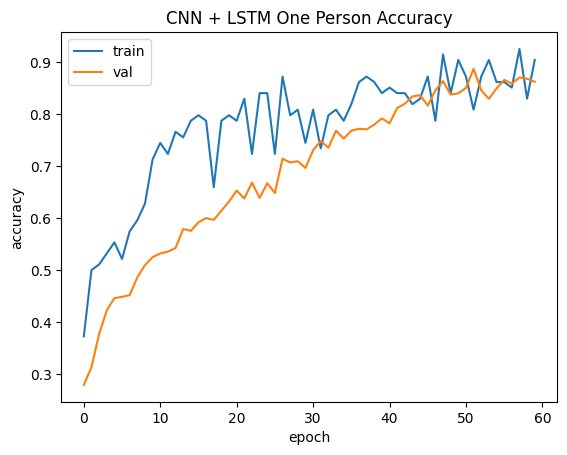

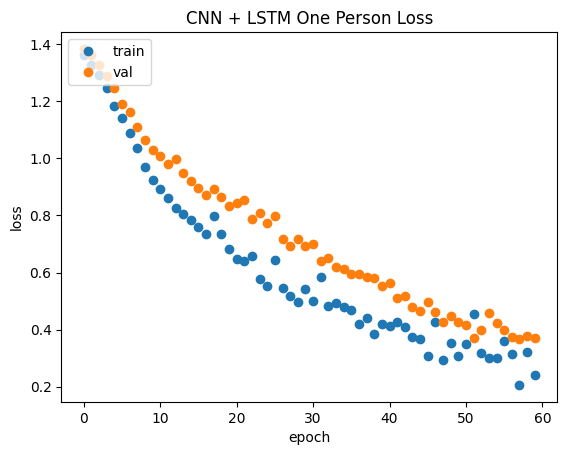

In [ ]:
# Model parameters
num_filters = [5]
filter_size = 5
dropout = 0.6
activation_func = 'elu'
dense_size = 100
lstm_dropout = 0.4
recurrent_dropout = 0.1
time_limit=800 # Cuts data at this number of samples


# Training parameters
epochs = 60
batch_size = 55
lr = 1e-3
verbose = True

print("#### Training model ONLY on subject 1. ###")
print("\nBuilding model...")
model = cnn_lstm(num_filters, filter_size, dropout, activation_func, dense_size, lstm_dropout, recurrent_dropout, time_limit)
print("\nBuilding train/val data")
x_train, y_train, x_val, y_val = train_val_data(subjects=1, time_limit=time_limit)
print("Using " + str(len(x_train)) + " training examples & " + str(len(x_val)) + " validation examples.")
print("\nTraining...")
_,_,trAcc, valAcc,trLoss,valLoss = train(model, x_train, y_train, x_val, y_val, epochs, batch_size, lr, verbose)
print("Finished training.")

print("\nTesting on data from subject 1.")
x_te, y_te = test_data(subjects=1,time_limit=time_limit)
acc = test(model, x_te, y_te)
print(str(acc) + "% accuracy on data subject 1.")

print("\nTesting on data from all subjects.")
x_te, y_te = test_data(time_limit=time_limit)
acc = test(model, x_te, y_te)
print(str(acc) + "% accuracy on data from all subjects.")

import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(valAcc)
plt.plot(trAcc)
plt.title('CNN + LSTM One Person Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(valLoss,'o')
plt.plot(trLoss,'o')
plt.title('CNN + LSTM One Person Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()